In [1]:
#Dependencies
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt 
#Import python for SQL and ORM
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

### Reflect database tables into SQLAlchemy ORM

In [2]:
#Create database connection
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
#Reflect existing database as new model
Base = automap_base()
#Reflect tables
Base.prepare(engine, reflect= True)
#View classes 
Base.classes.keys()

['measurement', 'station']

In [4]:
#Declare variable to reference each table
Measurement = Base.classes.measurement 
Station = Base.classes.station

In [5]:
#Link Python to database
session = Session(engine)

### Precipitation Analysis

In [207]:
#Calculate the date one year previous from today's date
year_ago = dt.date.today() - dt.timedelta(days= 365)

#Query to retrieve wanted data from table in database
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

#Save retrieved data in DataFrame
precipitation = pd.DataFrame(data, columns= ["Date", "Precipitation"])
#Set index
precipitation.set_index("Date", inplace=True)

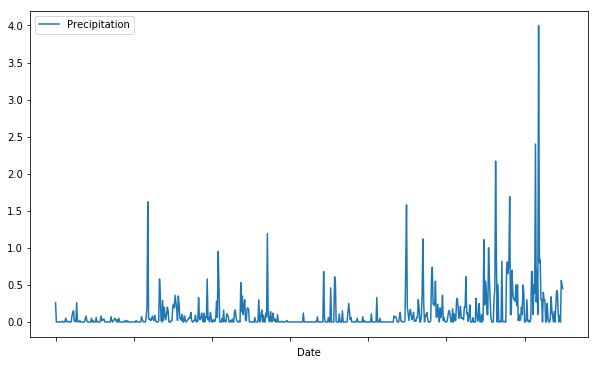

In [208]:
precipitation.plot(figsize=(10,6))
#plt.savefig("Images/precipitation_analysis.png")
plt.show()

In [15]:
#Display summary statistics for precipitation data
precipitation.describe()

,Precipitation
count,656.000000
mean,0.123643
std,0.299554
min,0.000000
25%,0.000000
50%,0.010000
75%,0.102500
max,4.000000


### Station Analysis

In [16]:
#Calculate total number of stations
session.query(func.count(Station.station)).all()

[(9)]

In [17]:
#Query to retrieve most active stations
station_count = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

#Display
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
#Define station with highest number of observatons
highest_observations = station_count[0]
highest_observations

('USC00519281', 2772)

In [25]:
#Query to retrieve last 12 months of tobs for the station with the highest number of observations
tobs_data = session.query((Measurement.tobs)).filter(Measurement.station == "USC00519281").\
filter(Measurement.date >= year_ago).all()

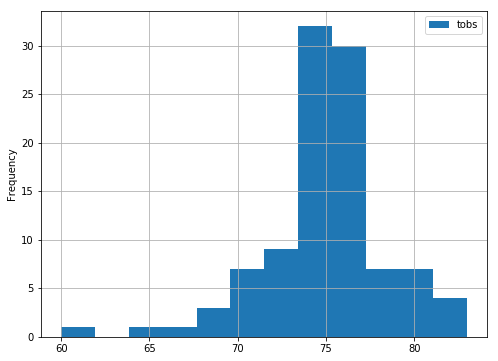

In [202]:
#Create Dataframe
top_station_df = pd.DataFrame(tobs_data)

#Create histogram
top_station_df.plot.hist(bins=12, figsize=(8,6))
plt.savefig("Images/station_analysis.png")
plt.grid()
plt.show()

In [49]:
#Define function called calc_temps
def calc_temps (start_date, end_date):
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

#Test for dates 4/30/17 - 5/5/17
print(calc_temps('2017-04-30', '2017-05-05'))    

[(58.0, 72.97142857142858, 79.0)]


In [69]:
#Mock trip = 8/1/18 - 8/10/18

#Set variables for trip dates correlating to previous year
prev_start_date = dt.date(2018, 8, 1) - dt.timedelta(days=365)
prev_end_date = dt.date(2018, 8, 10) - dt.timedelta(days=365)

#Calculate min, avg, and max temps for mock trip
temp_analysis = calc_temps(prev_start_date.strftime("%Y-%m-%d"), prev_end_date.strftime("%Y-%m-%d"))
print(temp_analysis)

[(71.0, 79.02564102564102, 83.0)]


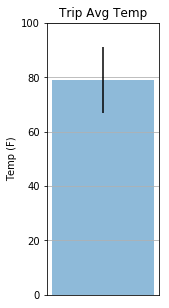

In [87]:
#Define variables for min, avg, and max temps
tmin = temp_analysis[0][0]
tavg = round(temp_analysis[0][1],1)
tmax = temp_analysis[0][2]

#Create Bar plot
plt.figure(figsize=(2,5))
plt.bar(1,height=tavg, yerr=(tmax-tmin), alpha=0.5)
plt.title("Trip Avg Temp")
plt.xticks([])
plt.ylim(0,100)
plt.ylabel("Temp (F)")
plt.savefig("Images/temperature_analysis.png")
plt.grid()
plt.show()

### Optional Analysis

In [139]:
#Mock trip = 8/1/18 - 8/10/18

#Define values wanted for analysis
values = [Station.station, Station.name, func.sum(Measurement.prcp)]

#Query to retrieve values
results = session.query(*values).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= prev_start_date).\
    filter(Measurement.date <= prev_end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()

#Create empty lists to store results
station = []
name = []
rain = []

#Loop through results
for result in results:
    station.append(result[:][0])
    name.append(result[:][1])
    rain.append(result[:][2])

#Display results for each station based on the specified dates of the trip
pd.DataFrame({"Station ID": station,
              "Name": name,
              "Rainfall": rain}, columns= ["Name", "Station ID", "Rainfall"])

,Name,Station ID,Rainfall
0,"MANOA LYON ARBO 785.2, HI US",USC00516128,0.92
1,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,0.32
2,"WAIHEE 837.5, HI US",USC00519281,0.06
3,"WAIKIKI 717.2, HI US",USC00519397,0.04
4,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,0.00


In [142]:
#Define function called daily_normals
def daily_normals(date):
    
    values = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    
    return session.query(*values).filter(func.strftime("%m-%d", Measurement.date) == date).all()

#Test for date 04-30  
daily_normals("04-30")

[(58.0, 71.5576923076923, 78.0)]

In [151]:
#Mock trip = 8/1/18 - 8/10/18

#Define variable for date range of trip based on 1 year previous since trip is in the future
trip_dates = pd.date_range(prev_start_date, prev_end_date)

#Convert dates in date range to m-d
trip = trip_dates.strftime("%m-%d")

#Create empty list to store trip dates daily normals
daily_norms = []

#Loop through trip dates for daily normals
for date in trip:
    daily_norms.append(*daily_normals(date))
    
#Display daily normals for trip dates
daily_norms

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0),
 (68.0, 76.5576923076923, 83.0),
 (69.0, 75.98039215686275, 81.0),
 (65.0, 76.42, 83.0)]

In [175]:
#Create Dataframe 
normals_df = pd.DataFrame(daily_norms, columns= ["min_temp", "avg_temp", "max_temp"])
#Add date column to Dataframe
normals_df["date"] = trip_dates
#Set date as index
normals_df.set_index(["date"], inplace=True)
#Display Dataframe
normals_df

#####Optional formating based on preference#####
#normals_df.style.format({"min_temp":"{:.1f}",
#                         "avg_temp":"{:.1f}",
#                         "max_temp":"{:.1f}"})

,min_temp,avg_temp,max_temp
date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0
2017-08-08,68.0,76.557692,83.0
2017-08-09,69.0,75.980392,81.0


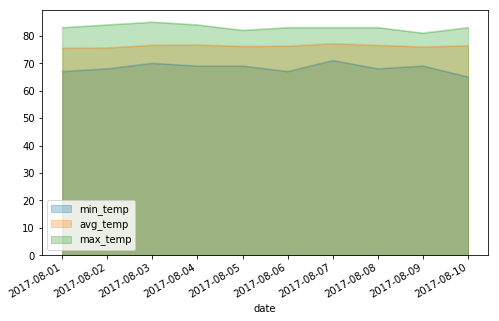

In [195]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind="area", stacked=False, alpha=0.3, x_compat=True, figsize=(8,5))
plt.savefig("Images/mock_trip_daily_normals.png")
plt.show()

In [7]:
#Create list of dates for the last 12 months
current_date = dt.datetime.strptime("2018-04-30", "%Y-%m-%d")
numdays = 365
date_list = [current_date - dt.timedelta(days=x) for x in range(0, numdays)]

#Convert dates to a list of strings
dates = []
for date in dates:
    new_date = date.strftime("%Y-%m-%d")
    dates.append(new_date)

In [9]:
#Query to retrieve precipitation data
prcp_query = session.query(func.avg(Measurement.prcp), Measurement.date)\
               .filter(Measurement.date.in_(dates))\
               .group_by(Measurement.date)

#Convert to a list
prcp_data = []
for result in prcp_query:
    prcp_data.append(result[0])

In [10]:
#Create DataFrame
prcp_df = pd.DataFrame([dates[::-1], prcp_data[::-1]]).T
prcp_df.rename(columns={0: "Date", 1: "Precipitation"}, inplace=True)
prcp_df.set_index("Date", inplace=True)
prcp_df.head()

,Precipitation
Date,
